<a href="https://colab.research.google.com/github/MariachiAncona/ProyectoFinal/blob/master/Proyecto_APIT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Proyecto: Modelo de lenguaje neuronal basado en la arquitectura de Bengio (2003)**

*   Aquino Santiago Rogelio Gerardo
*   Moreno Madrid Maria Guadalupe
*   Ramírez Ancona Simón Eduardo
*   Ruiz Pérez Ariel

### **Objetivo:**
A partir del corpus **corpusML.txt** realizar un modelo del lenguaje neuronal con base en la arquitectura propuesta por Bengio (2003).

### **Introducion:**


Los modelos del lenguajes son una herramienta esencial en el PLN. Éstos se utilizan en múltiples aplicaciones. Su objetivo es estimar probabilidades de cadenas:

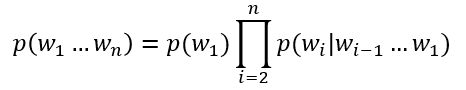

Aproximan estas probabilidades por medio de asumir la propiedad de Markov (n-gramas):

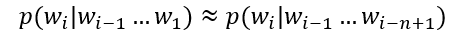

Un modelo (estadístico) del lenguaje es µ = (Σ, P), tal que Σ es vocabulario y P medida de probabilidad sobre $Σ^*$

Se busca estimar un modelo µ = (Σ, A, Π)tal que Σ es el vocabulario, A son probabilidades de transición:

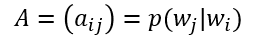

Y Π son probabilidades iniciales:

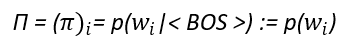

De esta forma, se pueden obtener las probabilidades de cadenas como:

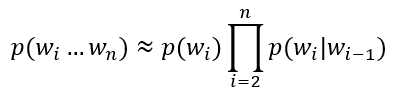

Bengio (2003) propone estimar los modelos del lenguaje a partir de las redes neuronales.
Sus objetivos son:

1.   Asociar cada palabra en el vocabulario con un vector distribuido en $R^b$
2.   Expresar la función de distribución conjunta de las secuencias de palabras por medio de estos vectores.
3.   Aprender de manera simultánea los vectores distribuidos y los parámetros de la función de probabilidad.






### **Desarrollo:**

0. __Lo primero será tener disponible el corpus.__

El corpus será una colección de tweets, cada uno de los que se obtengan con la herramienta twint será utilizado como una sentencia, que será almacenada como un elemento de la lista para entrenar y evaluar el modelo.


---
Instalando twint para obtener los datos que se usarán como entrada del modelo neuronal.

In [ ]:
!pip3 install -qq twint
!pip install -qq whatthelang
!pip3 install nest_asyncio
!pip3 install --upgrade -e git+https://github.com/twintproject/twint.git@origin/master#egg=twint

Obtaining twint from git+https://github.com/twintproject/twint.git@origin/master#egg=twint
  Updating ./src/twint clone (to revision origin/master)
  Running command git fetch -q --tags
  Running command git reset --hard -q origin/master
  Found existing installation: twint 2.1.21
    Can't uninstall 'twint'. No files were found to uninstall.
  Running setup.py develop for twint


In [ ]:
import twint

# Instantiate and configure the twint-object
c = twint.Config()
c.Store_object = True
c.Pandas =True
c.Search = "#Capitolio"
c.Limit = 1500
c.Lang = 'es'

In [ ]:
import nest_asyncio
nest_asyncio.apply()

# Run search
twint.run.Search(c)

# Quick check
twint.storage.panda.Tweets_df.head()

1348359789445836803 2021-01-10 20:03:19 +0000 <muralcom> El actor @Schwarzenegger comparó el reciente asalto al #Capitolio de #EU con la #Alemania #nazi, además que catalogó a #DonaldTrump como el "peor presidente de la historia de EU". #RegístrateGratis  https://t.co/hWU2QivNao
1348359440844673027 2021-01-10 20:01:56 +0000 <BettyLu770> @Politica2017 @CarlosVerareal JAMÁS PUDO PROBAR....  NO ES ASUNTO DE IMAGINAR NI DESEAR.... SINO DE DEMOSTRAR.   TODAS LAS INSTANCIAS  DECLARARON FALSAS LAS ACUSACIONES.  LO QUE NO ES FALSA LA #INSTIGACION   AL DESORDEN Y VIOLENCIA  QUE TERMINO CON EL  #ASALTO AL #CAPITOLIO.   HOMBRE INSENSATO LLENO DE ODIO
1348359049935527937 2021-01-10 20:00:23 +0000 <platnetworks> La policía de Seattle investiga a dos oficiales que estaban en DC en medio de disturbios en el Capitolio. #PlataformaLatina #Seattle #Policía #Oficiales #Capitolio #WashingtonDC  https://t.co/XxECgx6gHv
1348358953646739458 2021-01-10 20:00:00 +0000 <EsBarrio> #LoMasLeído  Ella es la mujer q

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1348359789445836803,1348359789445836803,1.610309e+12,2021-01-10 20:03:19,+0000,,El actor @Schwarzenegger comparó el reciente a...,es,"[capitolio, eu, alemania, nazi, donaldtrump, r...",[],34080203,34080203,muralcom,mural.com,7,20,https://twitter.com/muralcom/status/1348359789...,[https://mural.com.mx/zZxD4f],[],0,,False,1,0,0,,#Capitolio,,,,,,,[],,,,
1,1348359440844673027,1347885795160580098,1.610309e+12,2021-01-10 20:01:56,+0000,,@Politica2017 @CarlosVerareal JAMÁS PUDO PROBA...,es,"[instigacion, asalto, capitolio]",[],718835588061917184,718835588061917184,BettyLu770,Betty,7,20,https://twitter.com/BettyLu770/status/13483594...,[],[],0,,False,0,0,0,,#Capitolio,,,,,,,"[{'screen_name': 'Politica2017', 'name': 'Polí...",,,,
2,1348359049935527937,1348359049935527937,1.610309e+12,2021-01-10 20:00:23,+0000,,La policía de Seattle investiga a dos oficiale...,es,"[plataformalatina, seattle, policía, oficiales...",[],1267175416738885637,1267175416738885637,platnetworks,Plataforma Latina,7,20,https://twitter.com/platnetworks/status/134835...,[https://plataformalatina.com/2021/01/10/la-po...,[],0,,False,0,0,0,,#Capitolio,,,,,,,[],,,,
3,1348358953646739458,1348358953646739458,1.610309e+12,2021-01-10 20:00:00,+0000,,#LoMasLeído Ella es la mujer que falleció tra...,es,"[lomasleído, capitolio]",[],4893769032,4893769032,EsBarrio,Barrio,7,20,https://twitter.com/EsBarrio/status/1348358953...,[https://bit.ly/3nlJOYA],[https://pbs.twimg.com/media/ErOGnbtXcAAJWa-.jpg],1,https://pbs.twimg.com/media/ErOGnbtXcAAJWa-.jpg,False,0,0,1,,#Capitolio,,,,,,,[],,,,
4,1348358811204071429,1348358811204071429,1.610309e+12,2021-01-10 19:59:26,+0000,,#HojaDelLunesAlmeria-e https://t.co/yGgZJ8rK...,es,"[hojadellunesalmeria, eeuu, capitolio, covid19]",[],2228914730,2228914730,AP_APAlmeria,AP-APAL,7,19,https://twitter.com/AP_APAlmeria/status/134835...,[https://bit.ly/3sddrPE],[https://pbs.twimg.com/media/ErZVJuxXAAAaFVl.jpg],1,https://pbs.twimg.com/media/ErZVJuxXAAAaFVl.jpg,False,0,11,0,,#Capitolio,,,,,,,[],,,,


In [ ]:
# Cleanup
tweets = twint.storage.panda.Tweets_df.drop_duplicates(subset=['id'])

# Reindex
tweets.index = range(len(tweets))

# Remove non-english
from whatthelang import WhatTheLang
wtl = WhatTheLang()

# This function makes easy to handle exceptions (e.g. no text where text should be)
# not really needed but can be useful 

def detect_lang(text):
    try: 
        return wtl.predict_lang(text)
    except Exception:
        return 'exp'

# Added performance measure here...you can leave teh %%time line out

#%%time

tweets['lang'] = tweets['tweet'].map(lambda t: detect_lang(t))

# keep only english

tweets = tweets[tweets.lang == 'es']

In [ ]:
print(type(tweets))

corpus = []

for row in tweets.index:
  corpus.append(tweets['tweet'][row])

#print(corpus[:10])

#tweets.head()

#for i in range(10):
#  print(i,':',corpus[i],'\n')



<class 'pandas.core.frame.DataFrame'>


1. __Limpiar los textos y aplicar stemming a las palabras.__

Esta sección se realizó a partir de algunos pasos del archivo en [este enlace](https://colab.research.google.com/drive/17p3ef9HyZ9N9rixGdr5yhLd_VGT0zpNk?usp=sharing) además de que se usaron algunas de las bibliotecas, por ejemplo nltk y regex.

In [ ]:
import nltk
import regex as re
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Una vez disponible el corpus se procede a abrir el archivo y separar en tokens para poder aplicar el algoritmo de stemming (también parte de nltk).

Hasta este punto el corpus ha sido leído y tokenizado en una lista, lo siguiente es limpiar el corpus para eliminar signos de puntuación y símbolos innecesarios.
También se separará en conjunto de oraciones para entrenamiento y para prueba, usando sklearn.

In [ ]:
#Limpiando el corpus de signos y símbolos
sents = []
for sent in corpus:
  sents.append(str.lower(re.sub(r"[^\w]", " ", sent)))
print(sents[:5])

['el actor  schwarzenegger comparó el reciente asalto al  capitolio de  eu con la  alemania  nazi  además que catalogó a  donaldtrump como el  peor presidente de la historia de eu    regístrategratis  https   t co hwu2qivnao', ' politica2017  carlosverareal jamás pudo probar      no es asunto de imaginar ni desear     sino de demostrar    todas las instancias  declararon falsas las acusaciones   lo que no es falsa la  instigacion   al desorden y violencia  que termino con el   asalto al  capitolio    hombre insensato lleno de odio', 'la policía de seattle investiga a dos oficiales que estaban en dc en medio de disturbios en el capitolio   plataformalatina  seattle  policía  oficiales  capitolio  washingtondc  https   t co xxecgx6ghv', ' lomasleído  ella es la mujer que falleció tras intentar ingresar al  capitolio    https   t co rcrixdfsxy  https   t co hs36hvcrgu', ' hojadellunesalmeria e   https   t co yggzj8rkzf  ️40 nominados al  premiogabo  festivalgabo  fundaciongabo   ️ eeuu  u

Una vez limpio el corpus se aplica el algoritmo de stemming, en este caso el stemmer de porter genérico de nltk _PorterStemmer_ no ayudó mucho así que se usó un stemmer para el español, también proporcionado por nltk.

In [ ]:
#Importando un objeto stemmer de nltk.
#Se usará un stemmer para español porque el resultado no es
# muy bueno con porter, es casi la misma oración lo que 
#alterará las probabilidades.
#['comencé', 'a', 'trabajar', 'y', 'me',
# 'pegaron', 'me', 'maltrataron', 'con', 'chicot']

#from nltk.stem import PorterStemmer
#ps = PorterStemmer()

#Aplicando el stemming a las palabras.

from nltk.stem.snowball import SpanishStemmer

ps = SpanishStemmer()
types = []

for sent in sents:
  types.append([ps.stem(w) for w in sent.split(" ") if w != ""])
print(sents[:5])
print(types[:5])

['el actor  schwarzenegger comparó el reciente asalto al  capitolio de  eu con la  alemania  nazi  además que catalogó a  donaldtrump como el  peor presidente de la historia de eu    regístrategratis  https   t co hwu2qivnao', ' politica2017  carlosverareal jamás pudo probar      no es asunto de imaginar ni desear     sino de demostrar    todas las instancias  declararon falsas las acusaciones   lo que no es falsa la  instigacion   al desorden y violencia  que termino con el   asalto al  capitolio    hombre insensato lleno de odio', 'la policía de seattle investiga a dos oficiales que estaban en dc en medio de disturbios en el capitolio   plataformalatina  seattle  policía  oficiales  capitolio  washingtondc  https   t co xxecgx6ghv', ' lomasleído  ella es la mujer que falleció tras intentar ingresar al  capitolio    https   t co rcrixdfsxy  https   t co hs36hvcrgu', ' hojadellunesalmeria e   https   t co yggzj8rkzf  ️40 nominados al  premiogabo  festivalgabo  fundaciongabo   ️ eeuu  u

2. __Insertar símbolos de inicio y final de cadena.__

In [ ]:
for t in types:
  t.insert(0,"<BOS>")
  t.append("<EOS>")
print(types[:5])

[['<BOS>', 'el', 'actor', 'schwarzenegg', 'compar', 'el', 'recient', 'asalt', 'al', 'capitoli', 'de', 'eu', 'con', 'la', 'alemani', 'nazi', 'ademas', 'que', 'catalog', 'a', 'donaldtrump', 'com', 'el', 'peor', 'president', 'de', 'la', 'histori', 'de', 'eu', 'registrategratis', 'https', 't', 'co', 'hwu2qivna', '<EOS>'], ['<BOS>', 'politica2017', 'carlosverareal', 'jamas', 'pud', 'prob', 'no', 'es', 'asunt', 'de', 'imagin', 'ni', 'des', 'sin', 'de', 'demostr', 'tod', 'las', 'instanci', 'declar', 'fals', 'las', 'acus', 'lo', 'que', 'no', 'es', 'fals', 'la', 'instigacion', 'al', 'desord', 'y', 'violenci', 'que', 'termin', 'con', 'el', 'asalt', 'al', 'capitoli', 'hombr', 'insensat', 'llen', 'de', 'odi', '<EOS>'], ['<BOS>', 'la', 'polic', 'de', 'seattl', 'investig', 'a', 'dos', 'oficial', 'que', 'estab', 'en', 'dc', 'en', 'medi', 'de', 'disturbi', 'en', 'el', 'capitoli', 'plataformalatin', 'seattl', 'polic', 'oficial', 'capitoli', 'washingtondc', 'https', 't', 'co', 'xxecgx6ghv', '<EOS>'], ['

En esta misma sección se indexará el vocabulario y se agregarán etiquetas _"\<OOV\>"_ para los hápax del vocabulario. 
Una vez indexado el vocabulario las palabras de frecuencia 1 serán reemplazadas por la etiqueta mencionada.

In [ ]:
#Indexando el vocabulario
from collections import Counter,defaultdict
from itertools import chain

#Aprovechando collections
#Frecuencia de los tipos
freq_words=Counter( chain(*[' '.join(sent).lower().split() for sent in types]))

corpus_hapax = []

#Recorre y reemplaza las palabras de frec 1
for sent in types:
  sent_hapax =[]
  for w in sent:
    if freq_words[w.lower()] == 1:
      sent_hapax.append('<oov>')
    else:
      sent_hapax.append(w.lower())
  corpus_hapax.append(sent_hapax)

#Creando el diccionario con las palabras indexadas
vocab = defaultdict()
vocab.default_factory = lambda: len(vocab)
voc_index = [[vocab[word] for word in line] for line in types]


print(corpus_hapax[:5])
print(voc_index[:5])

[['<bos>', 'el', 'actor', 'schwarzenegg', 'compar', 'el', 'recient', 'asalt', 'al', 'capitoli', 'de', 'eu', 'con', 'la', 'alemani', 'nazi', 'ademas', 'que', 'catalog', 'a', 'donaldtrump', 'com', 'el', 'peor', 'president', 'de', 'la', 'histori', 'de', 'eu', 'registrategratis', 'https', 't', 'co', '<oov>', '<eos>'], ['<bos>', '<oov>', '<oov>', '<oov>', 'pud', 'prob', 'no', 'es', 'asunt', 'de', 'imagin', 'ni', 'des', 'sin', 'de', 'demostr', 'tod', 'las', '<oov>', 'declar', 'fals', 'las', 'acus', 'lo', 'que', 'no', 'es', 'fals', 'la', 'instigacion', 'al', 'desord', 'y', 'violenci', 'que', 'termin', 'con', 'el', 'asalt', 'al', 'capitoli', 'hombr', '<oov>', 'llen', 'de', 'odi', '<eos>'], ['<bos>', 'la', 'polic', 'de', 'seattl', 'investig', 'a', 'dos', 'oficial', 'que', 'estab', 'en', 'dc', 'en', 'medi', 'de', 'disturbi', 'en', 'el', 'capitoli', 'plataformalatin', 'seattl', 'polic', 'oficial', 'capitoli', 'washingtondc', 'https', 't', 'co', '<oov>', '<eos>'], ['<bos>', '<oov>', 'ella', 'es', 

In [ ]:
#freq_words
len(vocab)

5372

3. __Obtener los bigramas que aparecen en el texto.__



Para esta parte, se usarán algunas partes del código del profesor Victor Mijangos, alojado en [este enlace](https://github.com/VMijangos/Curso-Procesamiento-de-Lenguaje-Natural/blob/master/Notebooks/09b%20Language_model_bigram_big.ipynb).

In [ ]:
#Se crean los bigramas
bigrams = list(chain(*[zip(word,word[1:]) for word in voc_index]))

#Se obtiene la frecuencia de cada bigrama
frecBigrams = Counter(bigrams)

#Tamaño del vocabulario
N = len(vocab)

print('Tamaño del vocabulario:', N)
print("bigramas: ", len(bigrams))
print(bigrams[:10])

Tamaño del vocabulario: 5372
bigramas:  36357
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 1), (1, 5), (5, 6), (6, 7), (7, 8), (8, 9)]


4. __Entrenar con los bigramas la red neuronal y obtener los valores para los hiperparámetros. Tomar de 100 a 300 unidades para la capa oculta.__

Se realizará la importación de algunas bibliotecas no usadas hasta ahora para que los métodos de la clase propuesta funcionen. correctamente. Además se separan los bigramas (Que es lo que se usa para la red) en conjunto para entrenamiento y conjunto para pruebas.

In [ ]:
#Split en corpus train y test
from sklearn.model_selection import train_test_split
import numpy as np

#El 0.3 denota el tamaño de la prueba, en este caso 30% del conjunto
bigrams, bigrams_test = train_test_split(bigrams, test_size=0.3)
print("Entrenamiento: ",len(bigrams))
print("Pruebas: ",len(bigrams_test))
print(bigrams[:5])

Entrenamiento:  25449
Pruebas:  10908
[(43, 1), (4, 18), (44, 686), (2975, 2976), (26, 27)]


Utilizaremos una clase del modelo de Bengio, tomaremos la celda 17 del [código](https://github.com/penserbjorne/clase-pln-2020-2/blob/master/02_practica/practica_2.ipynb) donde está definida la clase a utilizar: 

In [ ]:
class Bengio:
  # Constructor del objeto
  def __init__(self, bigrams, T, d, m, n, N):
    self.bigrams = bigrams
    self.T = T    # Numero de iteraciones
    self.d = d    # Dimension de los embeddings
    self.m = m    # Numero de unidades en la capa oculta
    self.n = n    # Rango de aprendizaje
    self.N = N    # Tamaño del vocabulario

  def initialize_params(self):
    self.C = np.random.random((self.d, self.N))/np.sqrt(self.N)
    self.W = np.random.random((self.m, self.d))/np.sqrt(self.d)
    self.b = np.random.random(self.m)
    self.U = np.random.random((self.N, self.m))/np.sqrt(self.m)
    self.c = np.random.random(self.N)
    self.R = []
    self.R_it = 0

  def forward(self, i_x):
    c_i = self.C[:,i_x]
    if np.size(np.dot(self.W, c_i)) == np.size(self.b): 
      h_i = np.tanh(np.dot(self.W, c_i) + self.b)
    else:
      h_i = np.tanh(np.dot(self.W, c_i))
    a_i = np.dot(self.U, h_i) + self.c
    e_a = np.exp(a_i - a_i.max())
    p_wk_wi = e_a / e_a.sum()
    return (p_wk_wi, h_i)

  def risk(self, p_wk_wi, i_y):
    self.R_it -= np.log(p_wk_wi[i_y].sum())

  def saveRisk(self):
    self.R.append(self.R_it)

  def getRisk(self):
    return self.R

  def backward(self, i_y, p_wk_wi, h_i):
    d_out = np.array(p_wk_wi, copy=True) 
    d_out[i_y] -= 1
    d_h = (1 - (h_i*h_i)) * np.dot(d_out.T, self.U)
    d_c = np.dot(d_h.T, self.W)
    return (d_out, d_h, d_c)


  def updateWeights(self, d_out, h_i, d_h, d_c, i_x):
    self.U -= self.n * np.outer(d_out, h_i)
    self.W -= self.n * np.outer(d_h, self.C[:, i_x])
    self.c -= self.n * d_out
    self.C[:, i_x] -=  self.n * d_c
    self.b -= self.n * d_h

#Único método modificado para que no muestre cada iteración
  def train(self):
    for it in range(0, self.T):
      self.R_it = 0
      for pair in self.bigrams:
        i_x = pair[0]
        i_y = pair[1] #Restando el símbolo inicial
        p_wk_wi, h_i = self.forward(i_x)
        self.risk(p_wk_wi, i_y)
        d_out, d_h, d_c = self.backward(i_y, p_wk_wi, h_i)
        self.updateWeights(d_out, h_i, d_h, d_c, i_x)
      self.saveRisk()
      print("Epoch: ", it, "\tEntropia cruzada: ", self.R_it)
    print("Finished")

  def entropy_phrase(self, sentence):
    entropy = 0
    for pair in sentence:
      i_x = pair[0]
      i_y = pair[1]
      p_wk_wi, h_i = self.forward(i_x)
      entropy -= np.log(p_wk_wi[i_y].sum())
    return entropy

  def predict(self, i_x):
    return np.argmax(self.forward(i_x)[0])


Procedemos a crear el modelo con los parámetros.

In [ ]:
# Creamos objeto del modelo y lo entrenamos
# Los parámetros del constructor son:
#   bigrams, iteraciones, embeddings, uni capa oculta,
#   learning rate, tamaño del diccionario considerando bos y eos
modelo = Bengio(bigrams, 50, 100, 300, 0.01, N)
modelo.initialize_params()
modelo.train()

Epoch:  0 	Entropia cruzada:  153684.70787306796
Epoch:  1 	Entropia cruzada:  143724.19112354855
Epoch:  2 	Entropia cruzada:  138937.52521378378
Epoch:  3 	Entropia cruzada:  135671.63331476078
Epoch:  4 	Entropia cruzada:  132931.16007392626
Epoch:  5 	Entropia cruzada:  130415.01006174502
Epoch:  6 	Entropia cruzada:  127884.53892135549
Epoch:  7 	Entropia cruzada:  125317.65620901021
Epoch:  8 	Entropia cruzada:  122851.52158123747
Epoch:  9 	Entropia cruzada:  120654.79268966628
Epoch:  10 	Entropia cruzada:  118617.31590869326
Epoch:  11 	Entropia cruzada:  116701.48539770901
Epoch:  12 	Entropia cruzada:  114889.17149022633
Epoch:  13 	Entropia cruzada:  113169.65830889219
Epoch:  14 	Entropia cruzada:  111535.5266693203
Epoch:  15 	Entropia cruzada:  109982.70060040659
Epoch:  16 	Entropia cruzada:  108501.33766707001
Epoch:  17 	Entropia cruzada:  107069.02781511263
Epoch:  18 	Entropia cruzada:  105668.9137959722
Epoch:  19 	Entropia cruzada:  104298.10775652001
Epoch:  20 	

5. __Evaluar el modelo (con Entropía y Perplejidad).__

Para tener una idea de que tan bueno es el modelo que estimamos, podemos utilizar la entropía cruzada empírica dada por la función:

$$H_E(p) = -\frac{1}{M} \sum_{x_1,...,x_m}^N \log p(x_1, ...x_m)$$
En este caso, el modelo con menor entropía será aquel que mejor prediga una (o varias) cadenas no vistas. Por tanto, consideraremos que generaliza mejor.
La perplejidad se define en base a esta entropía como $2^{H_E(p)}$.

En nuestro caso para la entropía y perplejidad la clase tiene un método para recorrer los bigramas y calcular la entropía, que según como se dividió el conjunto solo le pasaremos como parámetro los bigramas de evaluación

In [ ]:
entropy_phrase = modelo.entropy_phrase(bigrams_test)

entropy_phrase /= len(bigrams_test)

print("Entropia del modelo evaluado: ", entropy_phrase)
print("Perplejidad del modelo: ", 2**entropy_phrase)

Entropia del modelo evaluado:  6.38691044607638
Perplejidad del modelo:  83.68577143038868


6. __Calcular la proabilidad de las siguientes oraciones:__
+ El capitolio apesta
+ Viva Trump muerte Biden
+ Pascuala ordeñaba las vacas

In [ ]:
# Creamos el corpus
c_t = """
El capitolio apesta\n
Viva Trump muerte Biden\n
Pascuala ordeñaba las vacas\n
"""
c_tl = []
for sent in c_t.split("\n"):
  if sent != '':
    c_tl.append(str.lower(re.sub(r"[^\w]", " ", sent)))

print(c_tl)

['el capitolio apesta', 'viva trump muerte biden', 'pascuala ordeñaba las vacas']




Stemmer:



In [ ]:
stems = []
for sent in c_tl:
  stems.append([ps.stem(w) for w in sent.split(" ") if w != "" and w != []])

print(stems[:5])

[['el', 'capitoli', 'apest'], ['viv', 'trump', 'muert', 'bid'], ['pascual', 'ordeñ', 'las', 'vac']]


Inserción de símbolos:

In [ ]:
for i,t in enumerate(stems):
    t.insert(0,"<BOS>")
    t.append("<EOS>")
   
print(stems)

[['<BOS>', 'el', 'capitoli', 'apest', '<EOS>'], ['<BOS>', 'viv', 'trump', 'muert', 'bid', '<EOS>'], ['<BOS>', 'pascual', 'ordeñ', 'las', 'vac', '<EOS>']]


In [ ]:
dic_wk_train = { w: idx for w,idx in vocab.items()}
n_stems = []

ids_tmp = []
for line in stems:
  for word in line:
    ids_tmp.append(dic_wk_train.get(word, dic_wk_train.get("<oov>")))

for line in stems:
  for word in line:
    n_stems.append(dic_wk_train.get(word, dic_wk_train.get("<oov>")))

n_bigrams = []
n_bigrams = list(zip(n_stems, n_stems[1:]))
print("Bigrama")
print(n_bigrams)

Bigrama
[(0, 1), (1, 8), (8, None), (None, 29), (29, 0), (0, 524), (524, 114), (114, 198), (198, 623), (623, 29), (29, 0), (0, None), (None, None), (None, 44), (44, None), (None, 29)]


Finalmente se calculan las probabilidades de las oraciones con los nuevos bigramas obtenidos de las oraciones.

In [ ]:
# Tomandoel modelo de Bengio
def prob_phrase_by_bengio(bigrams, model):
    prob = 1
    for bigram in bigrams:
        i_x = bigram[0]
        i_y = bigram[1]
        #Manejando <oov>
        if i_y is None: i_y, i_x = 0, 6
        if i_x is None: i_y, i_x = 6, 0
        prob *= model.forward(i_x)[0][i_y]
        print("P: ", prob)
    return prob

min_i = 0
max_i = 0

for line in stems:
    print(line)
    max_i += len(line) - 1
    prob = prob_phrase_by_bengio(n_bigrams[min_i:max_i], modelo)
    print("Probabilidad de la frase: ", prob, "\n")
    min_i = max_i + 1
    max_i += 1

['<BOS>', 'el', 'capitoli', 'apest', '<EOS>']
P:  0.04145319456917947
P:  0.0073384412166233705
P:  3.250048133271458e-10
P:  1.4393898032062577e-12
Probabilidad de la frase:  1.4393898032062577e-12 

['<BOS>', 'viv', 'trump', 'muert', 'bid', '<EOS>']
P:  0.00849352851555193
P:  1.134333600324001e-05
P:  1.9646209938718505e-12
P:  5.2995672731221006e-20
P:  4.057411859084998e-22
Probabilidad de la frase:  4.057411859084998e-22 

['<BOS>', 'pascual', 'ordeñ', 'las', 'vac', '<EOS>']
P:  4.4287990287491866e-08
P:  1.961426083704974e-15
P:  8.686815052753905e-18
P:  3.8472158068560306e-25
P:  1.703864981700558e-27
Probabilidad de la frase:  1.703864981700558e-27 



###**Referencias:**

*   https://colab.research.google.com/drive/17p3ef9HyZ9N9rixGdr5yhLd_VGT0zpNk?usp=sharing
*   https://github.com/VMijangos/Curso-Procesamiento-de-Lenguaje-Natural/blob/master/Notebooks/09b%20Language_model_bigram_big.ipynb
*   https://github.com/penserbjorne/clase-pln-2020-2/blob/master/02_practica/practica_2.ipynb
*   Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Jauvin.
A neural probabilistic language model.
Journal of machine learning research, 3(Feb):1137–1155, 2003.

